# Transfer Learning Part 1: Feature Extraction

In [ ]:
import tensorflow as tf

## What is Transfer learning???
Well someone has spent the time crafting the right model for the job

Example of Use cases:
* Computer Vision - Image net
* Natural Language processing




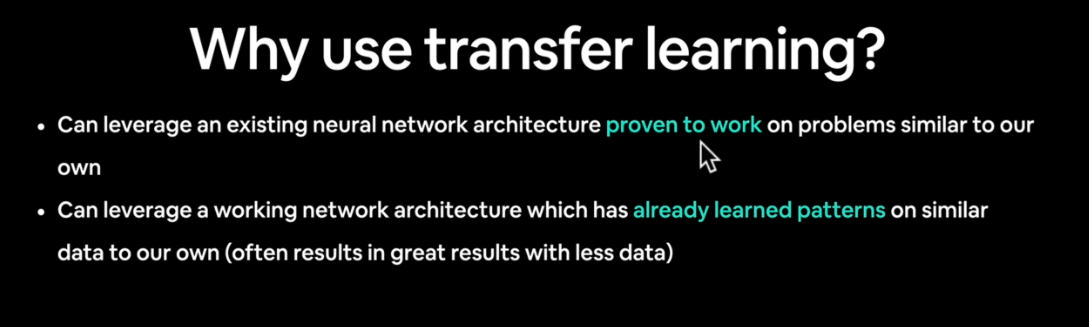

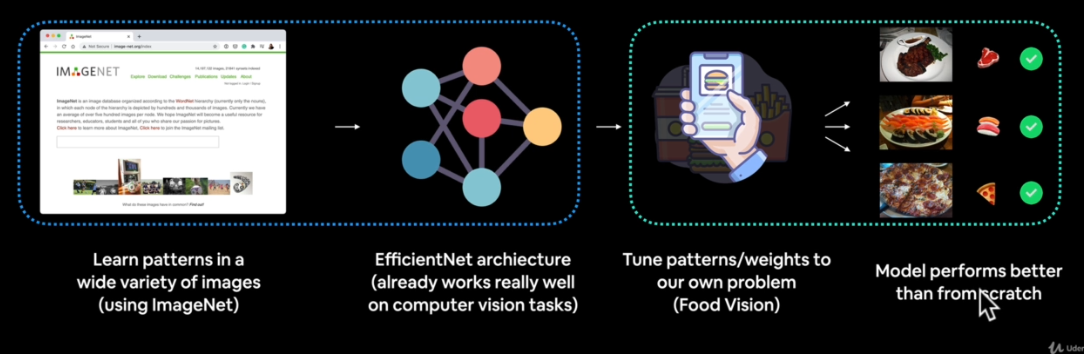

In [ ]:
!nvidia-smi

Sun Nov 17 14:12:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Become one with data


In [ ]:
# get 10% of 10class data
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2024-11-18 06:22:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.207, 74.125.134.207, 142.251.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   162MB/s    in 1.0s    

2024-11-18 06:22:27 (162 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [ ]:
# How many images in each folder
import os

# walk through the 10% of the data
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 10 director

In [ ]:
# Lets visualise the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


def view_random_image(target_dir, target_class):
  # Set up the target dir
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  # print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off');

  print(f"Image shape: {img.shape}")
  return img


Image shape: (512, 384, 3)


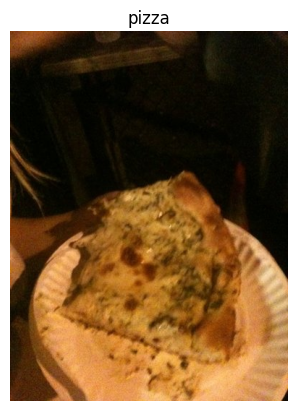

In [ ]:
img = view_random_image('10_food_classes_10_percent/train/', 'pizza')

## Creating the data loaders (preparing the data)
We'll use the `ImageDataGenerator` class to load in our images in batches

In [ ]:
# Setup the data inputs

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)


train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMG_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your model to be performed during or after training.
Most popular callbacks are:
* Tracking experiments with the `tensorboard callback`
* Model checkpoint with the `ModelCheckpoint Callback`
* Stopping a model from training (before it trains too long and overfits) with the `EarlyStopping Callbacks`


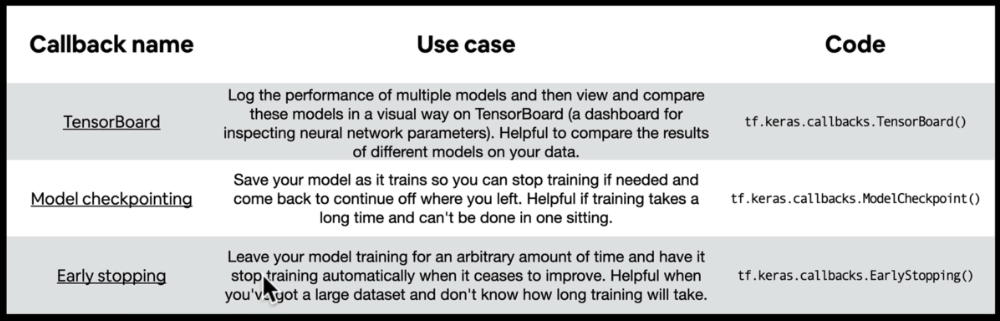

In [ ]:
# Create a tensorboard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


## Creating model using TensorFlow Hub

https://www.tfhub.dev/ <!-- Now the models are on kaggle -->

https://paperswithcode.com/sota <!-- Where you can find which model has performed best in our domain -->

In [ ]:
# Lets compare the following 2 model
resnet_url = "https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1"

efficient_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [ ]:
# Lets make a create_model() to create a model from url
def create_model(model_url, num_classes = 10):
  """
  Takes Tensorflow hub url (now from kaggle) and create a keras sequential model with it.

  Args:
    model_url: A tensorflow hub feature extraction url
    num_classes: No of output neurons in the output layer, should be equal to no of target classes we are working with.

  Return:
    An uncompiled Keras Sequential model with model_url as feature extractor layer,
    and Dense output layer with num_classes output neurons

  """

  # Download the pretrained model and save it as Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = 'feature_extraction_layer',
                                           input_shape = IMG_SHAPE + (3,)
                                           )
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation = 'softmax', name = "output_layer")
  ])
  return model



### Creating and testing the resnet tensorflow hub feature extraction model


In [ ]:
# Create resnet model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x78a679e90670> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [ ]:
# Compile the model

In [ ]:
resnet_model.summary()

In [ ]:
num_classes=train_data.num_classes

# ChatGPT Code

In [ ]:
import tensorflow_hub as hub
m = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
# m.build([None, expect_img_size, expect_img_size, 3])  # Batch input shape.


ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x78a67660afb0> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Parameters
IMG_SIZE = 224  # MobileNetV2 input size
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

train_dir = '10_food_classes_10_percent/train/'
validation_dir = '10_food_classes_10_percent/test/'

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the base model

# Add a new classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # Change 10 to the number of your classes
])

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Replace with the path to your dataset
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_data = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Train the model (Feature Extraction)
model.fit(
    train_data,
    validation_data=validation_data,
    epochs=EPOCHS
)

# Fine-tuning: Unfreeze some layers of the base model
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE / 10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model (Fine-tuning)
model.fit(
    train_data,
    validation_data=validation_data,
    epochs=EPOCHS
)

# Save the model
# model.save("transfer_learning_model.h5")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 164s 7s/step - accuracy: 0.2084 - loss: 2.3639 - val_accuracy: 0.6276 - val_loss: 1.2298
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 186s 8s/step - accuracy: 0.5867 - loss: 1.2871 - val_accuracy: 0.7264 - val_loss: 0.8705
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 192s 8s/step - accuracy: 0.6578 - loss: 1.0441 - val_accuracy: 0.7448 - val_loss: 0.7866
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 150s 6s/step - accuracy: 0.7359 - loss: 0.8410 - val_accuracy: 0.7476 - val_loss: 0.7525
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 235s 8s/step - accuracy: 0.7597 - loss: 0.7245 - val_accuracy: 0.7704 - val_loss: 0.6918
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.7314 - loss: 0.7834 - val_accuracy: 0.7688 - val_loss: 0.6889
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 153s 6s/step - accuracy: 0.7766 - loss: 0.6487 - val_accuracy: 0.7680 - val_loss: 0.6902
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - accuracy: 0.8275 - loss: 0.5540 - val_accuracy: 0.7820 - val_loss: 0.

In [ ]:
# Get the class names programmatically
import pathlib
import numpy as np

data_dir = pathlib.Path('data/pizza_steak/train')

# Lets create a list of class anmes from the sub directories
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Parameters
IMG_SIZE = 224  # Ensure it matches the input size of the model
CLASS_NAMES = ["class1", "class2", "class3", "class4", "class5",
               "class6", "class7", "class8", "class9", "class10"]  # Replace with your class names

# Load the trained model
model = load_model("transfer_learning_model.h5")

# Function to preprocess and predict
def predict_image(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0  # Normalize to range [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=-1)  # Get the class index
    confidence = np.max(predictions)  # Confidence score

    # Print result
    print(f"Predicted class: {CLASS_NAMES[predicted_class[0]]} with confidence {confidence:.2f}")
    return CLASS_NAMES[predicted_class[0]], confidence

# Example Usage
image_path = "path_to_your_image.jpg"
predicted_label, confidence_score = predict_image(image_path)


# From YouTube
* Lets use VGG16 model


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16


In [ ]:
conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (224, 224, 3)
                  )


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
VGGmodel = Sequential()
VGGmodel.add(conv_base)
VGGmodel.add(Flatten())
VGGmodel.add(Dense(10, activation = 'softmax'))

In [ ]:
VGGmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │         250,890 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,965,578 (57.09 MB)

 Trainable params: 14,965,578 (57.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
conv_base.trainable = False

In [ ]:
VGGmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │         250,890 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,965,578 (57.09 MB)

 Trainable params: 250,890 (980.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224, 224),
                                               batch_size=32,
                                               class_mode = 'categorical')


test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size = (224, 224),
                                               batch_size=32,
                                               class_mode = 'categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
VGGmodel.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
VGGmodel.fit(
    train_data,
    epochs = 5,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = test_data.samples // test_data.batch_size
)

Epoch 1/5
12/24 ━━━━━━━━━━━━━━━━━━━━ 3:59 20s/step - accuracy: 0.7531 - loss: 0.8515

## Types of Transfer Learning
* `As is` transfer learning - using an existing model with no changes whatsoever (e.g. using ImageNet model on 1000 ImageNet classes, none of our own)
* `Feature Extraction` transfer learning - Use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problems (e.g. 1000 classes -> 10 classes of food )
* `Fine Tuning` transfer learning - use the prelearned patterns of an existing model and  **fine tune** many or all underlying layers including new output later

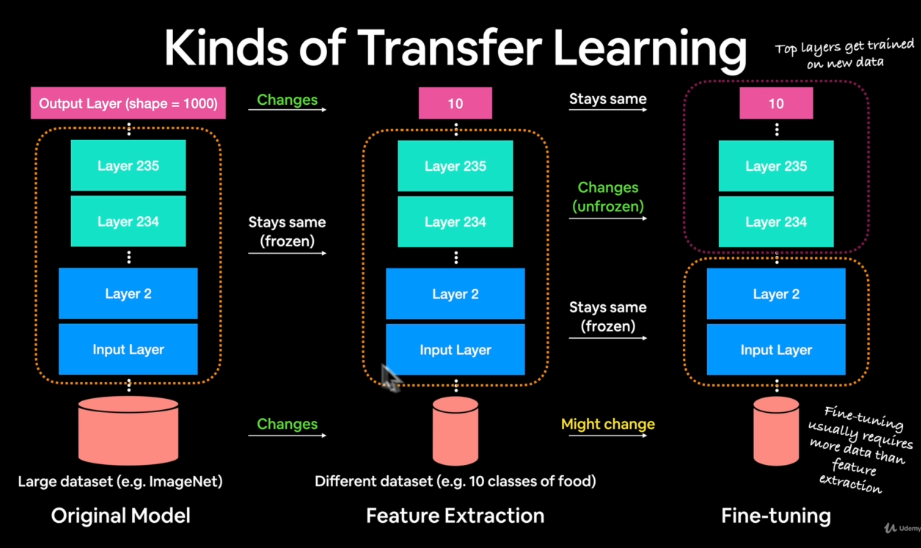

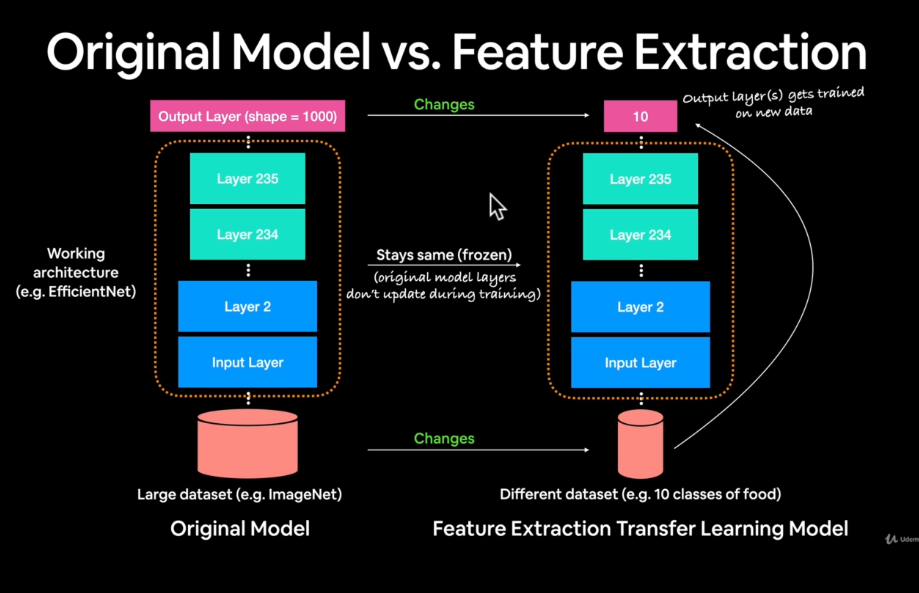
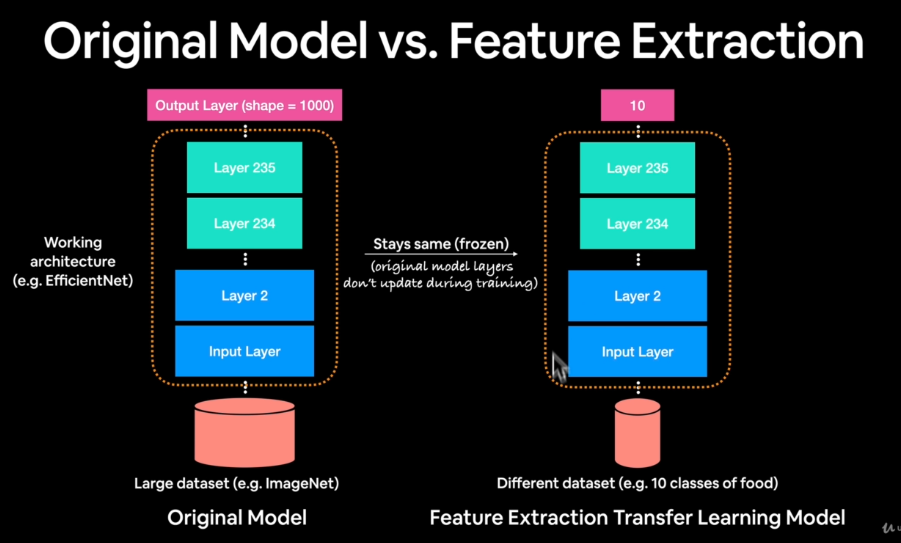

## Comparing our models result using TensorBoard
> **Note:** When you upload things on TensorBoard.dev, your experiments are public. So if you are runiing a private experiments do not upload them to tensorboard

In [ ]:
# Download tensorboard if not using colab

# Upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. VGG16" \
  --decscription "Comparing two different model" \
  --one_shot

In [ ]:
# Checkout the tensorboard experiments you have
!tensorboard dev list

In [ ]:
# Delete an experiment
!tensorboard dev delete --experiment_id EXPERIMENT_ID

In [ ]:
# confirm the deletion by listing the experiments again
!tensorboard dev list